In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from model import Market

import networkx as nx


In [2]:
n_households = 2
n_firms = 2
firms_production = 2
min_income = 1
max_income = 1
min_quality = 0
max_quality = 1
decrease_price = 0.7
increase_price = 0.3
price_change = 0

model = Market(F =n_firms, H=n_households, firms_production=firms_production, min_income=min_income, max_income=max_income, 
                min_quality=min_quality, max_quality=max_quality, decrease_price=decrease_price, increase_price=increase_price, price_change=price_change)
steps = 10
for i in range(steps):
    #print('step', i)
    model.step()
    

In [3]:
a = model.datacollector.get_agent_vars_dataframe()
a

Type   Quality  Revenue  Quantity_sold  Price  \
Step AgentID                                                       
0    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      0.0            0.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
1    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
2    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
3    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
4    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
5    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
6    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
7    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
8    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   
9    1        Household       NaN      NaN            NaN    NaN   
     2        Household       NaN      NaN            NaN    NaN   
     3             Firm  0.472121      2.0            2.0    1.0   
     4             Firm  0.143974      0.0            0.0    1.0   

              Initial_budget  budget  
Step AgentID                          
0    1                   1.0     1.0  
     2                   1.0     1.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
1    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
2    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
3    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
4    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
5    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN     NaN  
6    1                   1.0     0.0  
     2                   1.0     0.0  
     3                   NaN     NaN  
     4                   NaN   

In [ ]:
# draw the graph of the last step with  Weight
# remove the nodes with no edges
for i in range(len(model.graphs)):
    if i % 1 == 0:
        model.graphs[i].remove_nodes_from(list(nx.isolates(model.graphs[i])))
        # color the nodes by type
        color_map = []
        node_map = []
        pos = {}
        f = 1
        h = 1
        for node in model.graphs[i]:
            if type(node) is Firm:
                color_map.append('blue')
                node_map.append(50)
                pos[node] = (1, f * 10)
                f += 1
            else:
                color_map.append('red')
                node_map.append(2)
                pos[node] = (2, h)
                h += 1
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
        # draw the bipartite graph using the node color map

        nx.draw(model.graphs[i], with_labels=False, width=[model.graphs[i][u][v]['weight'] for u,v in model.graphs[i].edges()], node_color = color_map, node_size = node_map, pos=pos)
        #plt.show()



In [31]:
import seaborn as sns



In [33]:
df = model.datacollector.get_agent_vars_dataframe().reset_index()

In [34]:
# for each Step, computes the HHI for each Firm
df_firm = df.loc[df['Type'] == 'Firm']
# normalize df_firm['Revenue'] in each Step
df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
# square the Market_share
df_firm['R'] = df_firm['Market_share']**2
# compute the HHI
HHI = df_firm.groupby(['Step'])['R'].sum()

#df_firm['HHI'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x**2).groupby(['Step', 'Type']).transform('sum')



/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_15008/3487603048.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['Market_share'] = df_firm.groupby(['Step'])['Revenue'].transform(lambda x: x/x.sum())
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_15008/3487603048.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_firm['R'] = df_firm['Market_share']**2


/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_15008/3404758210.py:4: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  prev = nx.adjacency_matrix(model.graphs[i-1]).A
/var/folders/33/dr4cqnzj0597_7n7kbsrfht8cdq0jk/T/ipykernel_15008/3404758210.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  curr = nx.adjacency_matrix(model.graphs[i]).A


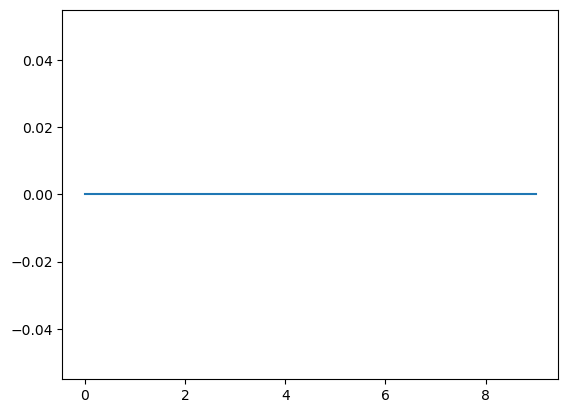

In [37]:
diff = [0]

for i in range(1, len(model.graphs)):
    prev = nx.adjacency_matrix(model.graphs[i-1]).A
    curr = nx.adjacency_matrix(model.graphs[i]).A
    change = sum(sum(abs(curr - prev)))
    maximum = sum(sum(prev))
    diff.append(change/maximum)

plt.plot(diff)

<AxesSubplot:xlabel='Step'>

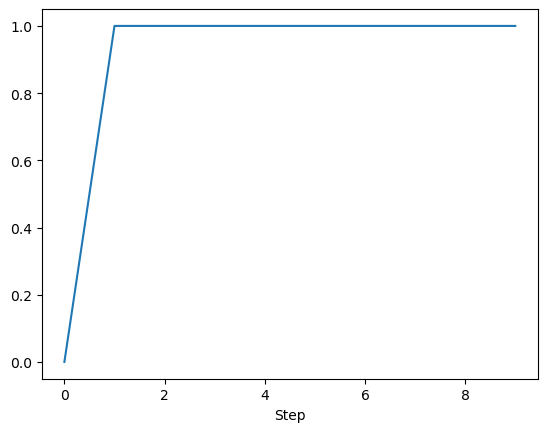

In [35]:
HHI.plot()

KeyboardInterrupt: 

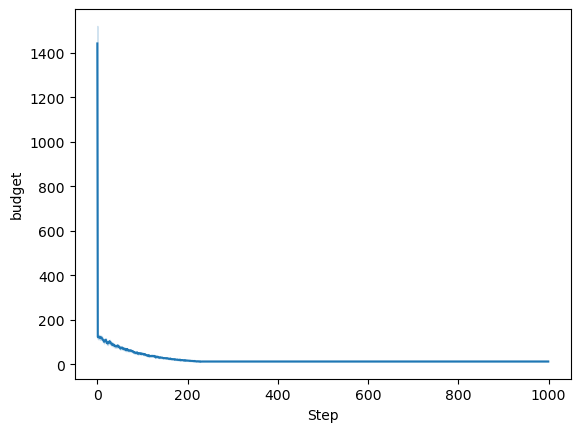

In [12]:
#sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')
sns.lineplot(data=df, y='budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Initial_budget', x='Step', estimator='sum')
sns.lineplot(data=df, y='Revenue', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Price'>

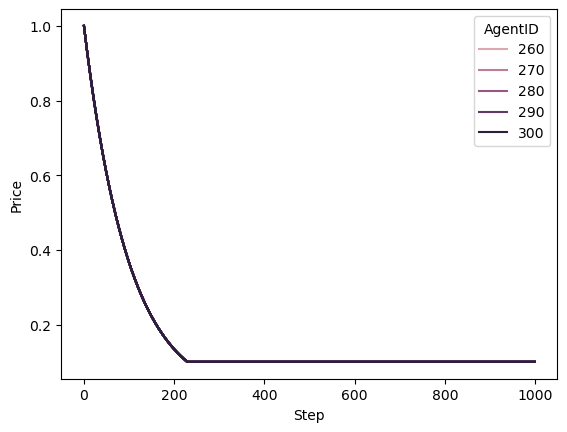

In [14]:
sns.lineplot(data=df_firm, y='Price', x='Step', hue = 'AgentID')

<AxesSubplot:xlabel='Step', ylabel='Quantity_sold'>

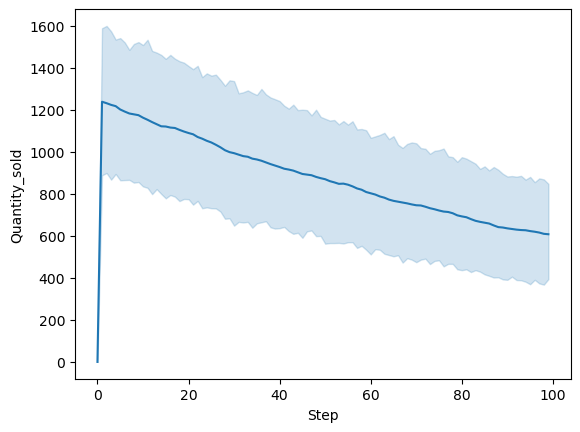

In [67]:
sns.lineplot(data=df, y='Quantity_sold', x='Step', estimator='sum')


<AxesSubplot:xlabel='Step', ylabel='Revenue'>

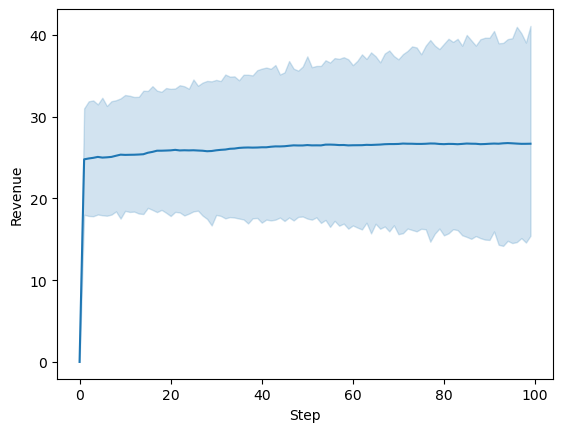

In [68]:
sns.lineplot(data=df, y='Revenue', x='Step')


<AxesSubplot:>

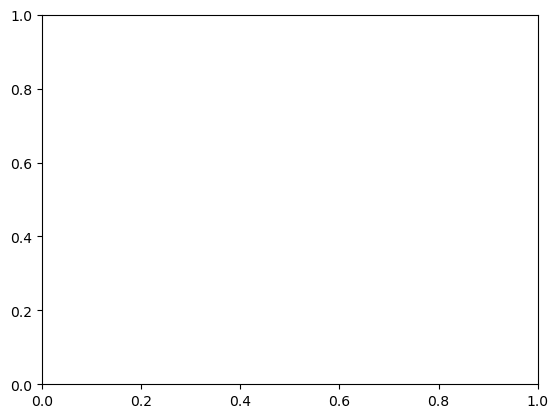

In [69]:
sns.lineplot(data=df.loc[df['AgentID'] == 1020],
             y='Revenue', x='Step', hue='AgentID')


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Household')].sort_values('budget')


In [ ]:
df.loc[(df['Step'] == 0) & (df['Type'] == 'Firm')].sort_values('Quality')


In [ ]:
sns.barplot(data=df.loc[(df['Step'] == 0) & (
    df['Type'] == 'Firm')], y='Quality', x='AgentID')


In [ ]:
df.loc[df['AgentID'] == 1009]


In [ ]:

# for each step plot use seaborn to do a 1x2 plot with the distribution of the "Price" and "Revenue" of the firms
for i in range(steps):
    if i % 10 == 0:
        df1 = df[df["Step"] == i]
        df1 = df1[df1["Type"] == "Firm"]
        fig, ax = plt.subplots(1, 2, figsize=(12, 5))

        sns.histplot(df1["Price"], ax=ax[0])
        sns.histplot(df1["Revenue"], ax=ax[1])
        # set the title of the plot to the step
        fig.suptitle("Step " + str(i))
        plt.show()


In [54]:
firms = df.loc[df['Type'] == "Firm"]
df.loc[(df['Type'] == "Firm") & (df['Step'] == 99)]['Revenue'].sum()
hhi = pd.DataFrame(data={'step': range(0,100)})
hhi = hhi.assign(volume=lambda x: df.loc[(df['Type'] == "Firm") & (df['Step'] == x.step)]['Revenue'].sum())
hhi 

ValueError: Can only compare identically-labeled Series objects